In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

MONAI中第一个例程：Medical Image Classification Tutorial with the MedNIST Dataset。MedNIST是从  TCIA, the RSNA Bone Age Challenge, and the NIH Chest X-ray dataset 收集和整理的数据集（Dr. Bradley J. Erickson M.D., Ph.D）。355

In [2]:
!pip install monai  # 安装MONAI软件包

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 47.0 MB/s eta 0:00:00


In [3]:
import os # 用于目录及文件操作，常用指令有os.listdirs(),os.path.join(),os.path.exists()
import shutil # 比os权限更高，可以删除目录
import tempfile # 临时文件操作
import matplotlib.pyplot as plt #数据可视化操作
import PIL # 图像处理库
import torch # 一种深度学习框架
from torch.utils.tensorboard import SummaryWriter # 记录训练过程中的统计信息，用于可视化训练过程
import numpy as np # 一种常用的矩阵数值计算的库
from sklearn.metrics import classification_report # 一种经典的机器学习软件库skleran，生成模型指标报告

In [4]:
from monai.apps import download_and_extract # 下载和提取数据集
from monai.config import print_config # 显示monai的配置信息，可以根据需要安装选装模块
from monai.data import decollate_batch, DataLoader# decollate_batch:将批量数据拆成单独的数据；DataLoader数据加载器
from monai.metrics import ROCAUCMetric #ROC AUC指标
from monai.networks.nets import DenseNet121 # 稠密卷积网络，2017年优秀CVPR文章
from monai.transforms import ( # monai的预处理函数
    Activations,#激活函数
    EnsureChannelFirst,#确保数据通道在第一位，满足pytorch数据格式要求
    AsDiscrete,# 将数据转换为离散值
    Compose,# 通过compose得到变换的结果，
    LoadImage,# 装载图像
    RandFlip,# 随机翻转
    RandRotate,# 随机旋转
    RandZoom,# 随机放大
    ScaleIntensity,# 改变图像的灰度值
)
from monai.utils import set_determinism # 用来设定随机数状态
 
print_config() # 打印monai的配置信息

MONAI version: 1.4.0
Numpy version: 1.26.4
Pytorch version: 2.4.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 46a5272196a6c2590ca2589029eed8e4d56ff008
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.5.1
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.23.2
scipy version: 1.14.1
Pillow version: 10.4.0
Tensorboard version: 2.16.2
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.19.0
tqdm version: 4.66.4
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.45.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [5]:
root_dir = r'/kaggle/working/'# r字符串可以保证/不是转义字符，使得目录写法与真实状态一致

In [6]:
resource = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/MedNIST.tar.gz"
md5 = "0bc7306e7427e00ad1c5526a6677552d" #数据资源为止
 
compressed_file = os.path.join(root_dir, "MedNIST.tar.gz")#设置压缩文件名字
data_dir = os.path.join(root_dir, "MedNIST")#设置数据文件名
if not os.path.exists(data_dir):#如果数据文件名不存在，
    download_and_extract(resource, compressed_file, root_dir, md5) # 下载数据数据

MedNIST.tar.gz: 59.0MB [00:02, 24.0MB/s]                            

2024-11-28 01:55:27,622 - INFO - Downloaded: /kaggle/working/MedNIST.tar.gz
2024-11-28 01:55:27,730 - INFO - Verified 'MedNIST.tar.gz', md5: 0bc7306e7427e00ad1c5526a6677552d.
2024-11-28 01:55:27,731 - INFO - Writing into directory: /kaggle/working/.


In [7]:
set_determinism(seed=0) # 设置随机数种子

In [8]:
# 通过列表表达式得到分类列表
class_names = sorted(x for x in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, x)))
# 获取标签数量
num_class = len(class_names)
# 通过列表表达式，得到各个文件夹下的文件名列表，image_files[0]是长度为1000的AbdomenCT 文件名列表
image_files = [
    [os.path.join(data_dir, class_names[i], x) for x in os.listdir(os.path.join(data_dir, class_names[i]))]
    for i in range(num_class)
]
# 列表表达式得到每一类数据个数的列表，应该为：[10000, 8954, 10000, 10000, 10000, 10000]
num_each = [len(image_files[i]) for i in range(num_class)]
image_files_list = []# 定义文件名列表
image_class = []#定义目标种类列表
for i in range(num_class): # 将二维图像文件名整合为一维列表。
    image_files_list.extend(image_files[i])# 图像文件名序列
    image_class.extend([i] * num_each[i])# 标签序列，与图像文件名序列长度相同
num_total = len(image_class) # 标签序列的长度就是总共的样本数量，即文件名序列长度。
image_width, image_height = PIL.Image.open(image_files_list[0]).size # 所有文件的图像数据都是相同大小，
#通过图像文件名列表的第一个文件获得图像的尺寸
 
print(f"Total image count: {num_total}")#输出样本总数
print(f"Image dimensions: {image_width} x {image_height}")#输出图像数据的尺寸 64×64
print(f"Label names: {class_names}")# 输出标签种类
print(f"Label counts: {num_each}") # 输出每个标签对用的图像数据数量

Total image count: 58954
Image dimensions: 64 x 64
Label names: ['AbdomenCT', 'BreastMRI', 'CXR', 'ChestCT', 'Hand', 'HeadCT']
Label counts: [10000, 8954, 10000, 10000, 10000, 10000]


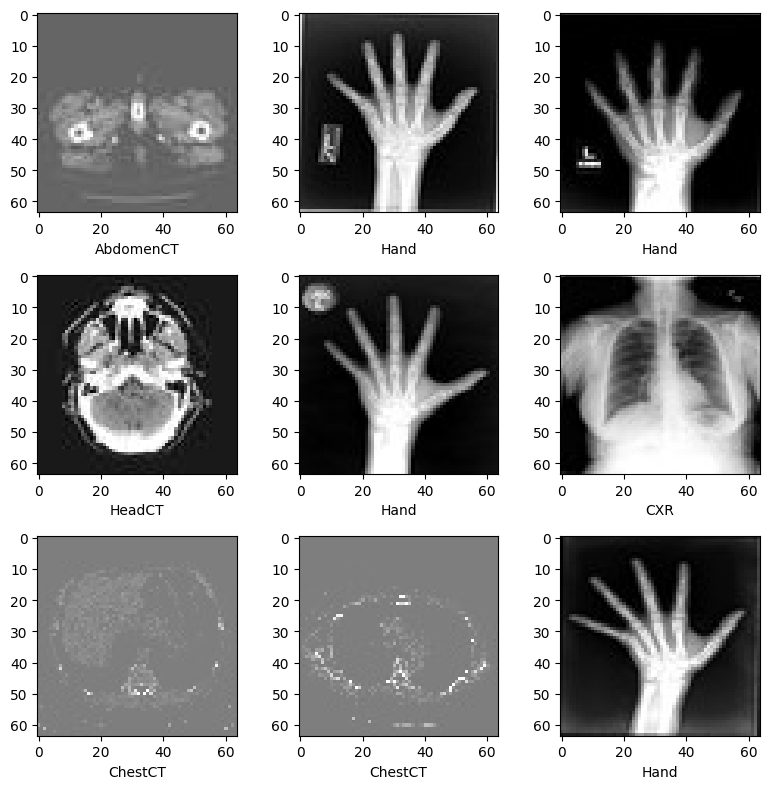

In [9]:
plt.subplots(3, 3, figsize=(8, 8))#建立包含 3×3 子窗口，尺寸为8×8英寸的图像窗口
for i, k in enumerate(np.random.randint(num_total, size=9)): # 从图像数据中随机抽取9个数
    im = PIL.Image.open(image_files_list[k]) # 利用PIL读取一个图像数据
    arr = np.array(im)# 转换为 ndarry数据类型
    plt.subplot(3, 3, i + 1)# 选中3×3窗口中的第i+1个窗口
    plt.xlabel(class_names[image_class[k]])# 再x坐标上写出该图像对应的种类
    plt.imshow(arr, cmap="gray", vmin=0, vmax=255)# 按照灰度显示图像，且仅显示0-255区域
#     plt.imshow(arr, cmap="gray")
plt.tight_layout()
plt.show()

因为数据集相对较大，一共有6万多张图片，因此训练集、验证集和测试集可以不按照7：2：1的方式划分。在本例程中，是按照8：1：1的方式来划分训练集、验证机和测试集的。对于分类问题，深度学习模型往往需要打乱数据顺序来消除数据先后顺序的影响。在实际应用中，不是在数据读入内存后再打乱顺序，而是通过对数据文件名进行随机排序。为了确保数据文件和标签在排序过程中保证对应关系不变，需要对序号（索引）序列进行操作。具体代码如下:

In [10]:
val_frac = 0.1 #设置验证集数据比例
test_frac = 0.1#设置测试集数据比例
length = len(image_files_list)#获得图像数据大小
indices = np.arange(length)# 获得0.。length-1的序号向量
np.random.shuffle(indices)# 打乱序号向量，消除数据先后顺序的影响
 
test_split = int(test_frac * length)#测试集大小
val_split = int(val_frac * length) + test_split#验证机大小
test_indices = indices[:test_split]#取得测试集序号序列
val_indices = indices[test_split:val_split]#取得验证集序号序列
train_indices = indices[val_split:]#剩下的就是训练集序号序列
 
train_x = [image_files_list[i] for i in train_indices]# 通过训练集序号序列，得到训练集文件名列表。
train_y = [image_class[i] for i in train_indices]# 通过训练集序号序列，得到训练集对应的标签列表。
val_x = [image_files_list[i] for i in val_indices]# 通过验证集序号序列，得到验证集文件名列表。
val_y = [image_class[i] for i in val_indices]# 通过验证集序号序列，得到训练集对应的标签列表。
test_x = [image_files_list[i] for i in test_indices]# 通过测试集序号序列，得到测试集文件名列表。
test_y = [image_class[i] for i in test_indices]# 通过测试集序号序列，得到测试集文件名列表。
# 打印出训练集、验证集和测试集数据长度
print(f"Training count: {len(train_x)}, Validation count: " f"{len(val_x)}, Test count: {len(test_x)}")

Training count: 47164, Validation count: 5895, Test count: 5895


MONAI中的transforms模块包含了所有的图像数据预处理操作，通过下面的设置，分别定义好了训练集变换train_transforms，验证集变换val_transforms，预测结果变换y_pred_trans，图像种类（标签）变换y_trans，只要正确引用下述变换，就可以对数据完成预先定义的预处理操作。具体代码及注释如下：


In [11]:
#对于训练集图像数据，进行图像数据载入、图像数据通道前移、灰度归一化，随机翻转、旋转和放大等操作，提升数据多样性
train_transforms = Compose(# 用Compose通过列表组合多个变换(预处理)操作
    [
        LoadImage(image_only=True),# 只读入图像数据
        EnsureChannelFirst(),# 确保把图形数据的通道放在第一位，满足torch框架要求
        ScaleIntensity(),# 把输入图像数据灰度值缩放到0-1范围内
        RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True),# 50%概率产生-pi/12-pi/12角度的旋转，图像尺寸不变
        RandFlip(spatial_axis=0, prob=0.5),# 50%概率产生围绕纵轴的图像翻转
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),# 50%概率产生0.9-1.1的图像分辨率缩放
    ]
)
# 对验证集数据进行以下操作：图像数据载入、通道前移和灰度归一化操作
val_transforms = Compose([LoadImage(image_only=True), EnsureChannelFirst(), ScaleIntensity()])
# 对于预测数据的操作为 softmax激活函数，因为标签种类数为6，需要采用softmax分类，得到属于每一类的概率值。
y_pred_trans = Compose([Activations(softmax=True)])
# 把数据转换为离散值，采用onehot编码
y_trans = Compose([AsDiscrete(to_onehot=num_class)])